# Example: Analysis of RISC-V Instruction Traces with MLonMCU

When experimenting with different RISC-V instruction set extension, it might be helpful to find out which types of instrcutions are really used.

## Supported components

**Models:** Any (`sine_model` used below)

**Frontends:** Any (`tflite` used below)

**Frameworks/Backends:** Any (`tflmi` used below)

**Platforms/Targets:** `etiss`, `spike`, `ovpsim` (`etiss` used below)

## Prerequisites

Set up MLonmCU as usual, i.e. initialize an environment and install all required dependencies. Feel free to use the following minimal `environment.yml.j2` template:

```yaml
---
home: "{{ home_dir }}"
logging:
  level: DEBUG
  to_file: false
  rotate: false
cleanup:
  auto: true
  keep: 10
paths:
  deps: deps
  logs: logs
  results: results
  plugins: plugins
  temp: temp
  models:
    - "{{ home_dir }}/models"
    - "{{ config_dir }}/models"
repos:
  tvm:
    url: "https://github.com/apache/tvm.git"
    ref: de6d8067754d746d88262c530b5241b5577b9aae
  etiss:
    url: "https://github.com/tum-ei-eda/etiss.git"
    ref: 4d2d26fb1fdb17e1da3a397c35d6f8877bf3ceab
  mlif:
    url: "https://github.com/tum-ei-eda/mlonmcu-sw.git"
    ref: 4b9a32659f7c5340e8de26a0b8c4135ca67d64ac
frameworks:
  default: tvm
  tvm:
    enabled: true
    backends:
      default: tvmaotplus
      tvmaotplus:
        enabled: true
        features: []
    features: []
frontends:
  tflite:
    enabled: true
    features: []
toolchains:
  gcc: true
platforms:
  mlif:
    enabled: true
    features: []
targets:
  default: etiss_pulpino
  etiss_pulpino:
    enabled: true
    features:
      log_instrs: true
```

Do not forget to set your `MLONMCU_HOME` environment variable first if not using the default location!

## Usage

The following examples demonstrates the powerful combination Postprocesses and Features provided by MLonMCU for the described use-case.

### A) Command Line Interface

Add the following arguments to your command:

`--feature log_instrs --config log_instrs.to_file=1 --postprocess analyse_instructions`

**Example:**

In [3]:
!mlonmcu flow run sine_model --backend tflmi --target etiss --config etiss.end_to_end_cycles=1 \
        --feature log_instrs --config log_instrs.to_file=1 --postprocess analyse_instructions

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-368]  Processing stage LOAD
INFO - [session-368]  Processing stage BUILD
INFO - [session-368]  Processing stage COMPILE
INFO - [session-368]  Processing stage RUN
INFO - [session-368]  Processing stage POSTPROCESS
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-368] Done processing runs
INFO - Report:
   Session  Run       Model Frontend Framework     Backend Platform         Target  Cycles  MIPS  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data      Features                                             Config           Postprocesses Comment
0      368    0  sine_model   tflite       tvm  tvmaotplus     mlif  etiss_pulpino    5826     0      56100       2737           4280     51676       144      2493                 244  [log_instrs]  {'tflite.use_inout_data': False, 'tflite

The interesting data is exported as an artifact and not shown in the report above. Therefore let's look at the generated files instead.

In [8]:
!mlonmcu export /tmp/exported/ -f --run
!ls /tmp/exported/

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
Creating directory: /tmp/exported
Done
analyse_instructions_majors.csv  metrics.csv
analyse_instructions_seq1.csv	 mlif
analyse_instructions_seq2.csv	 mlif_out.log
analyse_instructions_seq3.csv	 parameters
aot_wrapper.c			 report.csv
codegen				 runtime
custom.ini			 run.txt
default.tar			 sine_model.tflite
etiss_pulpino_instrs.log	 src
etiss_pulpino_out.log		 tvmaot_workspace_size.txt
generic_mlif			 tvmc_compile_out.log
metadata.json			 tvm_wrapper.h


CSV File of the used instruction classes (RISC-V only):

In [15]:
!cat /tmp/exported/analyse_instructions_majors.csv | column -t -s,

column: line too long
Major                Count  Probablity
OP-IMM (Compressed)  714    0.124
LOAD-FP              595    0.103
JALR (Compressed)    560    0.097
LOAD (Compressed)    477    0.083
STORE (Compressed)   457    0.079
BRANCH               451    0.078
STORE                315    0.055
OP-IMM               313    0.054
MADD                 288    0.050


Frequently used instructions:

In [16]:
!cat /tmp/exported/analyse_instructions_seq1.csv | column -t -s,

column: line too long
Sequence  Count  Probablity
flw       595    0.103
caddi     433    0.075
cswsp     415    0.072
cmv       343    0.059
clwsp     343    0.059
fmadd_s   288    0.050
fsw       277    0.048
addi      183    0.032
sw        174    0.030


### B) Python Scripting

Python Imports

In [17]:
from tempfile import TemporaryDirectory
from pathlib import Path
import pandas as pd

from mlonmcu.context.context import MlonMcuContext
from mlonmcu.session.run import RunStage

Benchmark Configuration

In [18]:
FRONTEND = "tflite"
MODEL = "sine_model"
BACKEND = "tvmaotplus"
PLATFORM = "mlif"
TARGET = "etiss_pulpino"
FEATURES = ["log_instrs"]
CONFIG = {"log_instrs.to_file": True}
POSTPROCESSES = ["analyse_instructions"]

Initialize and run a single benchmark

In [19]:
with MlonMcuContext() as context:
    session = context.create_session()
    run = session.create_run(config=CONFIG)
    run.add_features_by_name(FEATURES, context=context)
    run.add_frontend_by_name(FRONTEND, context=context)
    run.add_model_by_name(MODEL, context=context)
    run.add_backend_by_name(BACKEND, context=context)
    run.add_platform_by_name(PLATFORM, context=context)
    run.add_target_by_name(TARGET, context=context)
    run.add_postprocesses_by_name(POSTPROCESSES)
    session.process_runs(context=context)
    report = session.get_reports()
report.df

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-369] Processing all stages
WARNING - unexpected script output (cycles)
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-369] Done processing runs


,Session,Run,Model,Frontend,Framework,Backend,Platform,Target,Cycles,MIPS,Total ROM,Total RAM,ROM read-only,ROM code,ROM misc,RAM data,RAM zero-init data,Features,Config,Postprocesses,Comment
0,369,0,sine_model,tflite,tvm,tvmaotplus,mlif,etiss_pulpino,None,0,56100,2737,4280,51676,144,2493,244,[log_instrs],"{'tflite.use_inout_data': False, 'tflite.visua...",[analyse_instructions],-


The report is available as pandas dataframe.

Let's extract the artifacts created by the `analyse_instructions` postprocess:

In [20]:
artifacts = session.runs[0].artifacts_per_stage[RunStage.POSTPROCESS]["default"]

**Visualization of used Instruction types**

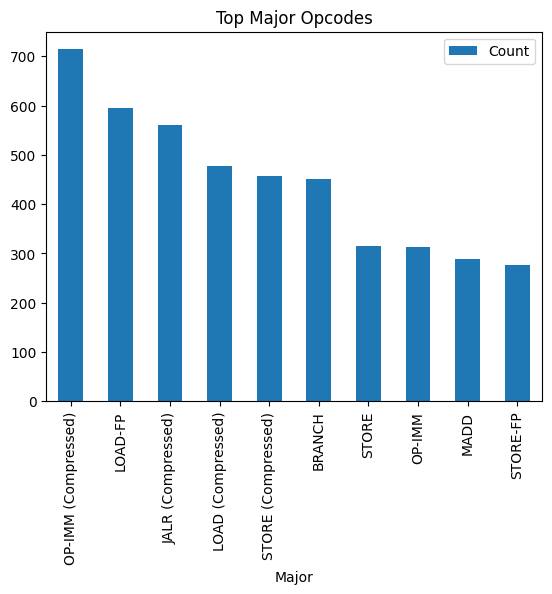

In [21]:
with TemporaryDirectory() as tmpdirname:
    dest = Path(tmpdirname) / "analyse_instructions_majors.csv"
    artifacts[0].export(dest)
    majors_df = pd.read_csv(dest)
    majors_df = majors_df.drop("Probablity", axis=1)
    majors_df.plot.bar(x="Major", title=f"Top Major Opcodes")

**Most used (groups of) intructions in the program**

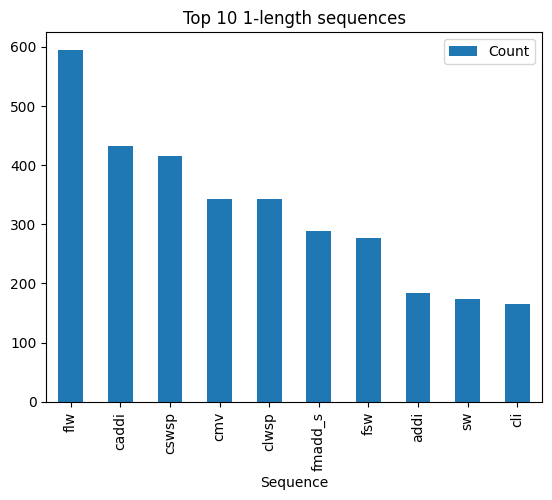

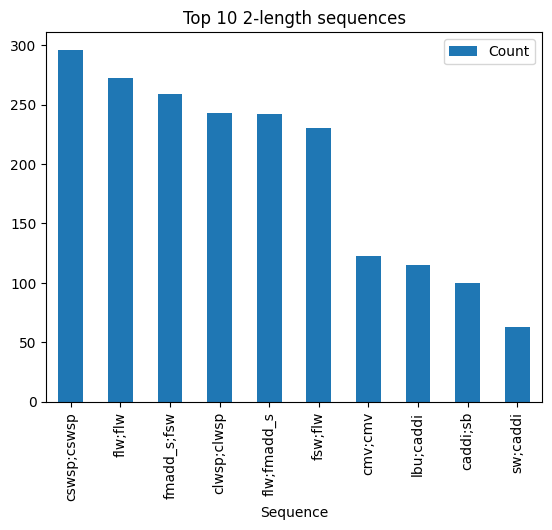

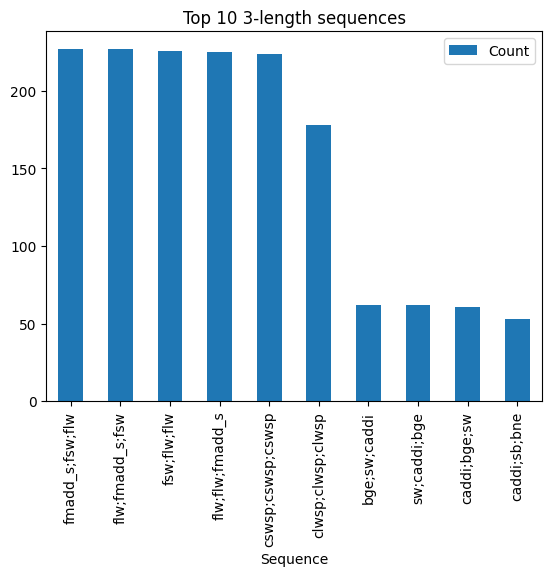

In [22]:
with TemporaryDirectory() as tmpdirname:
    for i in range(1, 4):
        dest = Path(tmpdirname) / f"analyse_instructions_seq{i}.csv"
        artifacts[i].export(dest)
        seq_df = pd.read_csv(dest)
        top = len(seq_df)
        seq_df = seq_df.drop("Probablity", axis=1)
        seq_df.plot.bar(x="Sequence", title=f"Top {top} {i}-length sequences")